In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

In [4]:
# Définir une palette de couleurs
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Charger les données
file_path = 'Domiciliation new_ 2019_2024.csv'
domiciliation = pd.read_csv(file_path, delimiter=';')

In [5]:
# Nettoyage des noms de colonnes pour enlever les espaces
domiciliation.columns = domiciliation.columns.str.strip()

# Conversion des types de données
domiciliation['DOUV'] = pd.to_datetime(domiciliation['DOUV'], format='%d/%m/%Y')
domiciliation['MONT_LOC'] = pd.to_numeric(domiciliation['MONT_LOC'], errors='coerce')
domiciliation['YEAR'] = domiciliation['DOUV'].dt.year

In [7]:
# Calculer des statistiques supplémentaires pour chaque client
client_stats = domiciliation.groupby('NOM client').agg({
    'MONT_LOC': ['sum', 'mean', 'count'],
    'YEAR': 'nunique'
})
client_stats.columns = ['Total_MONT_LOC', 'Mean_MONT_LOC', 'Domiciliation_Count', 'Active_Years']

# Vérification des types de données
print(client_stats.dtypes)


Total_MONT_LOC         float64
Mean_MONT_LOC          float64
Domiciliation_Count      int64
Active_Years             int64
dtype: object


In [8]:
# Normaliser les données
scaler = StandardScaler()
client_stats_normalized = scaler.fit_transform(client_stats)

In [9]:
# Appliquer le modèle de mélange gaussien (GMM)
gmm = GaussianMixture(n_components=4, random_state=42)
client_stats['Cluster'] = gmm.fit_predict(client_stats_normalized)

In [10]:
# Analyser les segments pour déterminer des noms pertinents
clusters = client_stats.groupby('Cluster').mean()

print("Caractéristiques moyennes des clusters :")
print(clusters)

Caractéristiques moyennes des clusters :
         Total_MONT_LOC  Mean_MONT_LOC  Domiciliation_Count  Active_Years
Cluster                                                                  
0          2.065556e+10   4.988836e+08            57.565476      3.613095
1          2.416472e+08   5.663916e+07             4.362126      1.794020
2          8.366011e+11   4.413832e+09           967.250000      5.250000
3          3.005508e+10   7.670566e+07           334.333333      6.000000


In [11]:
# Renommer les clusters en fonction des caractéristiques observées
cluster_names = {
    0: 'Clients à Faible Valeur',
    1: 'Clients à Haute Fréquence',
    2: 'Clients Premium',
    3: 'Clients à Moyenne Valeur'
}
client_stats['Cluster Name'] = client_stats['Cluster'].map(cluster_names)

In [12]:
# Merge les résultats de clustering avec les données originales
domiciliation = domiciliation.merge(client_stats[['Cluster', 'Cluster Name']], left_on='NOM client', right_index=True, how='left')



Top 10 des Clients à Faible Valeur :
NOM client
ABASSE DISTRIBUTION              4.178116e+11
LOUIS DREYFUS COMPANY SENEGAL    2.077111e+11
EIFFAGE GC MARINE SENEGAL        2.064771e+11
ICS                              1.837787e+11
CBMI CONSTRUCTION CO. LTD        1.629216e+11
MADTRANS                         1.471419e+11
PETOWAL MINING COMPANY SA        1.193649e+11
VIVO ENERGY SENEGAL              1.065037e+11
SI.TRA.COM SARL                  9.099091e+10
SIDICOM - SARL                   8.738066e+10
Name: MONT_LOC, dtype: float64


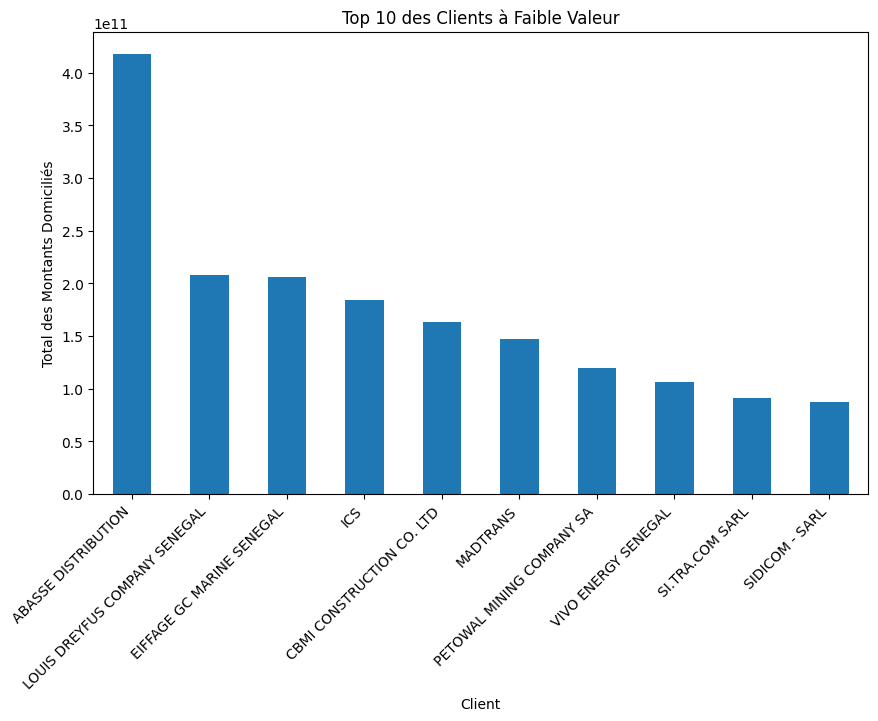


Top 10 des Clients à Haute Fréquence :
NOM client
ISLE GRANULATES & SERVICES SA           1.613021e+09
FOOD AND SWEETS PRODUCTION COMPANY      1.483001e+09
LEKKUFII                                1.332196e+09
SUEZ INTERNATIONAL SENEGAL              1.315984e+09
CFAO TECHNOLOGIES                       1.286360e+09
MAJOREL SENEGAL                         1.182354e+09
STE INGENI. CONSTRUCT° TRAV. MAINT.     1.130801e+09
FLEXEAU SA                              1.109520e+09
SC TUBULAR SOLUTIONS SENEGAL SARL       1.080055e+09
CHINA MACHINERY ENGINEERING CORP SEN    1.065265e+09
Name: MONT_LOC, dtype: float64


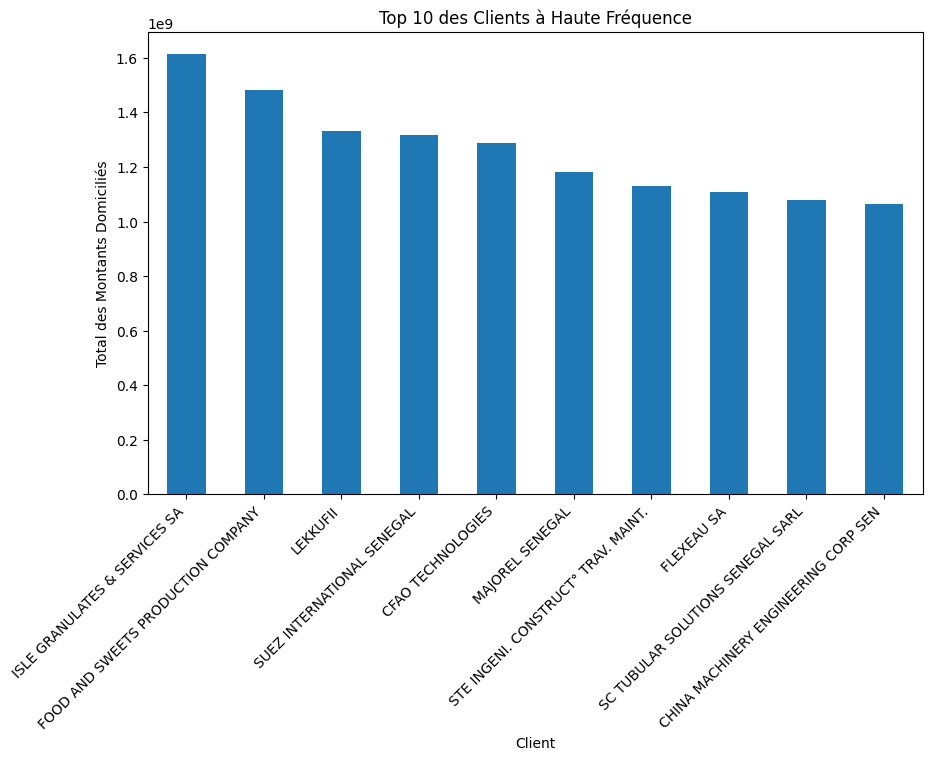


Top 10 des Clients Premium :
NOM client
SABODALA GOLD OPERATIONS              1.559278e+12
TOTALENERGIES MARKETING SENEGAL SA    1.273668e+12
COMPT COM MAND                        4.482007e+11
DAKAR MOBILITE                        6.525780e+10
Name: MONT_LOC, dtype: float64


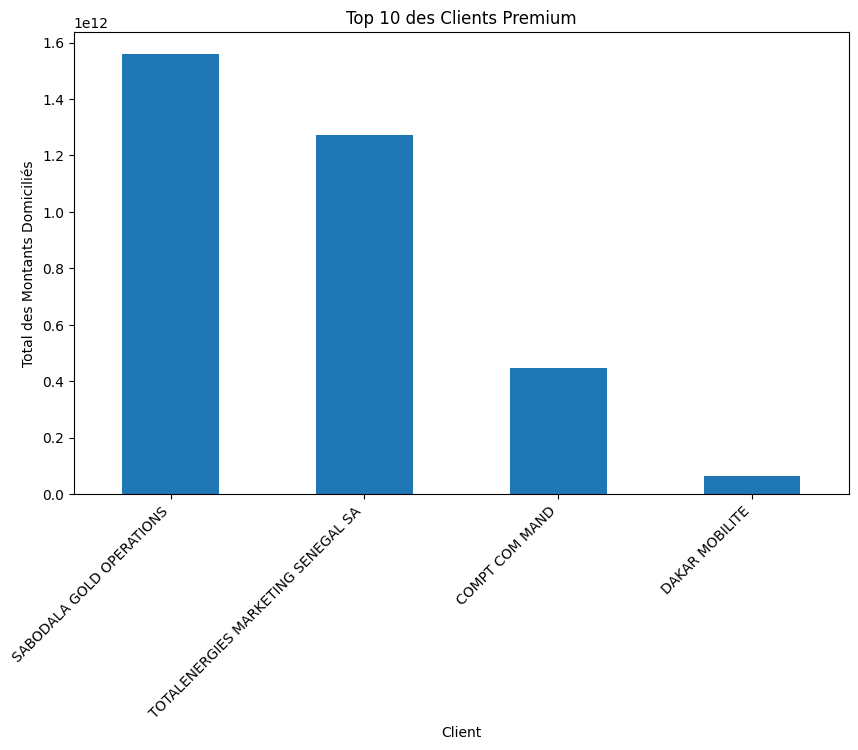


Top 10 des Clients à Moyenne Valeur :
NOM client
GRANDE COTE OPERATION                   8.375744e+11
SENECOR                                 3.141903e+11
COMPAGNIE SENEGALAISE DE LUBRIFIANTS    1.718101e+11
SENICO                                  1.364940e+11
SENEGALAISE DE L'AUTOMOBILE             1.000347e+11
PATISEN                                 8.580610e+10
LA ROCHETTE DAKAR S.A                   6.501348e+10
LES GRANDS DOMAINES DU SENEGAL          6.265409e+10
VAN OERS SENEGAL - SARL                 5.970783e+10
UNIPARCO                                5.963847e+10
Name: MONT_LOC, dtype: float64


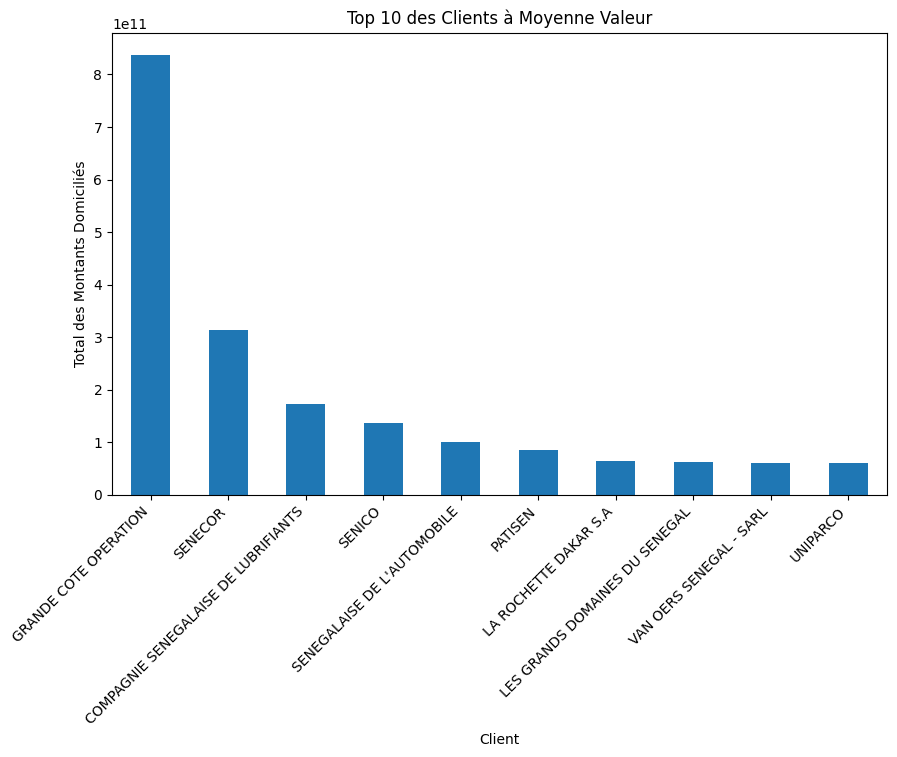

In [13]:
# Afficher le top 10 des clients par cluster
for cluster_id, cluster_name in cluster_names.items():
    print(f"\nTop 10 des {cluster_name} :")
    filtered_data = domiciliation[domiciliation['Cluster Name'] == cluster_name]
    if filtered_data.empty:
        print(f"Aucun client trouvé pour {cluster_name}")
        continue
    top_10_clients = filtered_data.groupby('NOM client')['MONT_LOC'].sum().sort_values(ascending=False).head(10)
    print(top_10_clients)
    
    plt.figure(figsize=(10, 6))
    top_10_clients.plot(kind='bar', title=f'Top 10 des {cluster_name}')
    plt.xlabel('Client')
    plt.ylabel('Total des Montants Domiciliés')
    plt.xticks(rotation=45, ha='right')
    plt.show()

Les segments ont été déterminés à l'aide du modèle de mélange gaussien (GMM) en utilisant les données normalisées des clients. Voici les segments avec des descriptions basées sur les caractéristiques moyennes des clusters :

Clients à Faible Valeur :

Caractéristiques :
Montant Total Domicilié : Faible
Montant Moyen Domicilié : Faible
Nombre de Domiciliations : Bas
Années Actives : Peu nombreuses
Description :
Ces clients effectuent un nombre limité de transactions avec des montants relativement bas. Ils sont peut-être de petites entreprises ou des particuliers ayant peu de besoins financiers.
Stratégie :
Offrir des incitations pour augmenter leur engagement, tels que des réductions sur les frais de service ou des conseils financiers personnalisés pour les aider à croître.
Clients à Haute Fréquence :

Caractéristiques :
Montant Total Domicilié : Modéré
Montant Moyen Domicilié : Modéré
Nombre de Domiciliations : Élevé
Années Actives : Plusieurs années
Description :
Ces clients effectuent fréquemment des transactions, mais les montants totaux restent modérés. Ils peuvent être des entreprises avec des flux de trésorerie fréquents ou des particuliers actifs financièrement.
Stratégie :
Optimiser les services pour répondre à leurs besoins fréquents, par exemple en leur offrant des services bancaires automatisés ou des applications mobiles pour faciliter les transactions.
Clients Premium :

Caractéristiques :
Montant Total Domicilié : Très élevé
Montant Moyen Domicilié : Très élevé
Nombre de Domiciliations : Variable
Années Actives : Plusieurs années
Description :
Ces clients représentent une grande valeur pour la banque en raison des montants élevés domiciliés. Ils sont probablement des grandes entreprises, des multinationales ou des particuliers fortunés.
Stratégie :
Fournir un service client personnalisé et des offres exclusives, comme des gestionnaires de compte dédiés, des produits financiers spécialisés et des avantages VIP.
Clients à Moyenne Valeur :

Caractéristiques :
Montant Total Domicilié : Modéré à élevé
Montant Moyen Domicilié : Modéré
Nombre de Domiciliations : Modéré
Années Actives : Quelques années
Description :
Ces clients effectuent un nombre modéré de transactions avec des montants modérés à élevés. Ils peuvent être des entreprises de taille moyenne ou des particuliers avec une activité financière significative.
Stratégie :
Augmenter leur valeur en leur proposant des produits et services adaptés, tels que des prêts commerciaux, des lignes de crédit ou des conseils en investissement pour maximiser leurs gains.